In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (16,10)

# Car Pricing

You've been given a dataset describing various features of some cars including their list price.

  * https://m2pi.syzygy.ca/data/CarPrice_Assignment.csv

You've been asked to explore this dataset, present some summary statistics and (hopefully) build a model for setting the list price. We've broken the problem down into 3 stages...


### Part 1: Exploration and Cleaning
1. Read in this data, clean and tidy it
1. Calculate basic statistics to understand what you have been given
1. Select some columns which might be correlated with price

### Part 2: Analysis and Model Building
1. Quantify correlations between columns
1. Create training and testing sets
1. Fit a pricing model

### Part 3: Results
1. Summarize your findings

### Part 1

In addition to local files, `pandas.read_csv` can ingest data from URLs (`s3` or `http`)

In [12]:
wCSV = 'https://m2pi.syzygy.ca/data/CarPrice_Assignment.csv'
wDF = pd.read_csv(
    wCSV,
    usecols=[
        'CarName',
        'doornumber',
        'drivewheel', # Important category?
        'curbweight', # Yes
        'enginesize', # Yes
        'compressionratio', # No
        'horsepower', # Yes
        'peakrpm', # Noa
        'price'    
    ]
)

`pd.DataFrame.head()` can give you a quick idea of what you have

In [13]:
wDF.head()

,CarName,doornumber,drivewheel,curbweight,enginesize,compressionratio,horsepower,peakrpm,price
0,alfa-romero giulia,two,rwd,2548,130,9.0,111,5000,13495.0
1,alfa-romero stelvio,two,rwd,2548,130,9.0,111,5000,16500.0
2,alfa-romero Quadrifoglio,two,rwd,2823,152,9.0,154,5000,16500.0
3,audi 100 ls,four,fwd,2337,109,10.0,102,5500,13950.0
4,audi 100ls,four,4wd,2824,136,8.0,115,5500,17450.0


For the numerical columns, we `pd.DataFrame.describe()` can provide basic summary statistics, often this can help you spot coding errors or other issues in the raw data.

In [14]:
wDF.describe()

,curbweight,enginesize,compressionratio,horsepower,peakrpm,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,2555.565854,126.907317,10.142537,104.117073,5125.121951,13276.710571
std,520.680204,41.642693,3.972040,39.544167,476.985643,7988.852332
min,1488.000000,61.000000,7.000000,48.000000,4150.000000,5118.000000
25%,2145.000000,97.000000,8.600000,70.000000,4800.000000,7788.000000
50%,2414.000000,120.000000,9.000000,95.000000,5200.000000,10295.000000
75%,2935.000000,141.000000,9.400000,116.000000,5500.000000,16503.000000
max,4066.000000,326.000000,23.000000,288.000000,6600.000000,45400.000000


`pd.DataFrame.describe()` only shows us the numerical fields, for categorical fields like `doornumber` and `drivewheel` we have to do something else. Often it is useful to start by examining all of the unique values. For text fields you'll often see coding errors, typos and other gotchas. For example, if we look at the unique values of `CarName` there are some typos

In [15]:
np.unique(wDF[wDF['CarName'].str.contains('toy')]['CarName'])

array(['toyota carina', 'toyota celica gt', 'toyota celica gt liftback',
       'toyota corolla', 'toyota corolla 1200',
       'toyota corolla 1600 (sw)', 'toyota corolla liftback',
       'toyota corolla tercel', 'toyota corona', 'toyota corona hardtop',
       'toyota corona liftback', 'toyota corona mark ii',
       'toyota cressida', 'toyota mark ii', 'toyota starlet',
       'toyota tercel', 'toyouta tercel'], dtype=object)

`'toyouta tercel'` is clearly a typo. In this case we're not expecting the car price to vary with name so we can ignore it. It is worth doing the same thing with any categorical fields you have to look for similar problems. Another issue is the choice of encoding. `doornumber` takes only two values: `'two'` or `'four'`, since these are numerical and have a natural order I would be tempted to replace them with their numerical value. You can do this _after_ reading in the CSV or during that process (with converters).

In [16]:
wDF['doornumber'].replace({'two': 2, 'four': 4}, inplace=True)
wDF.head()

,CarName,doornumber,drivewheel,curbweight,enginesize,compressionratio,horsepower,peakrpm,price
0,alfa-romero giulia,2,rwd,2548,130,9.0,111,5000,13495.0
1,alfa-romero stelvio,2,rwd,2548,130,9.0,111,5000,16500.0
2,alfa-romero Quadrifoglio,2,rwd,2823,152,9.0,154,5000,16500.0
3,audi 100 ls,4,fwd,2337,109,10.0,102,5500,13950.0
4,audi 100ls,4,4wd,2824,136,8.0,115,5500,17450.0


`drivewheel` only has 3 values (`'fwd'`, `'rwd'` or `'4wd'`), but they don't really have a natural order. Another strategy for dealing with them would be to encode them as dummy/indicator values. This will add columns for the 3 values and encode e.g. `rwd` as a 1 in `drivewheel_rwd` column. Pandas has a method called `pd.get_dummies` to help with this. While we're at it I'm going to drop the `CarName` column since we don't need it.

In [17]:
wDF = pd.get_dummies(wDF.drop(['CarName'], axis=1))

Next we can do a pairplot to look for correlations visually. This will take the values for each pair of columns and plot them against each other. We are interested in price so we are looking for plots which show linear (or anti-linear) behaviour when plotted against price.

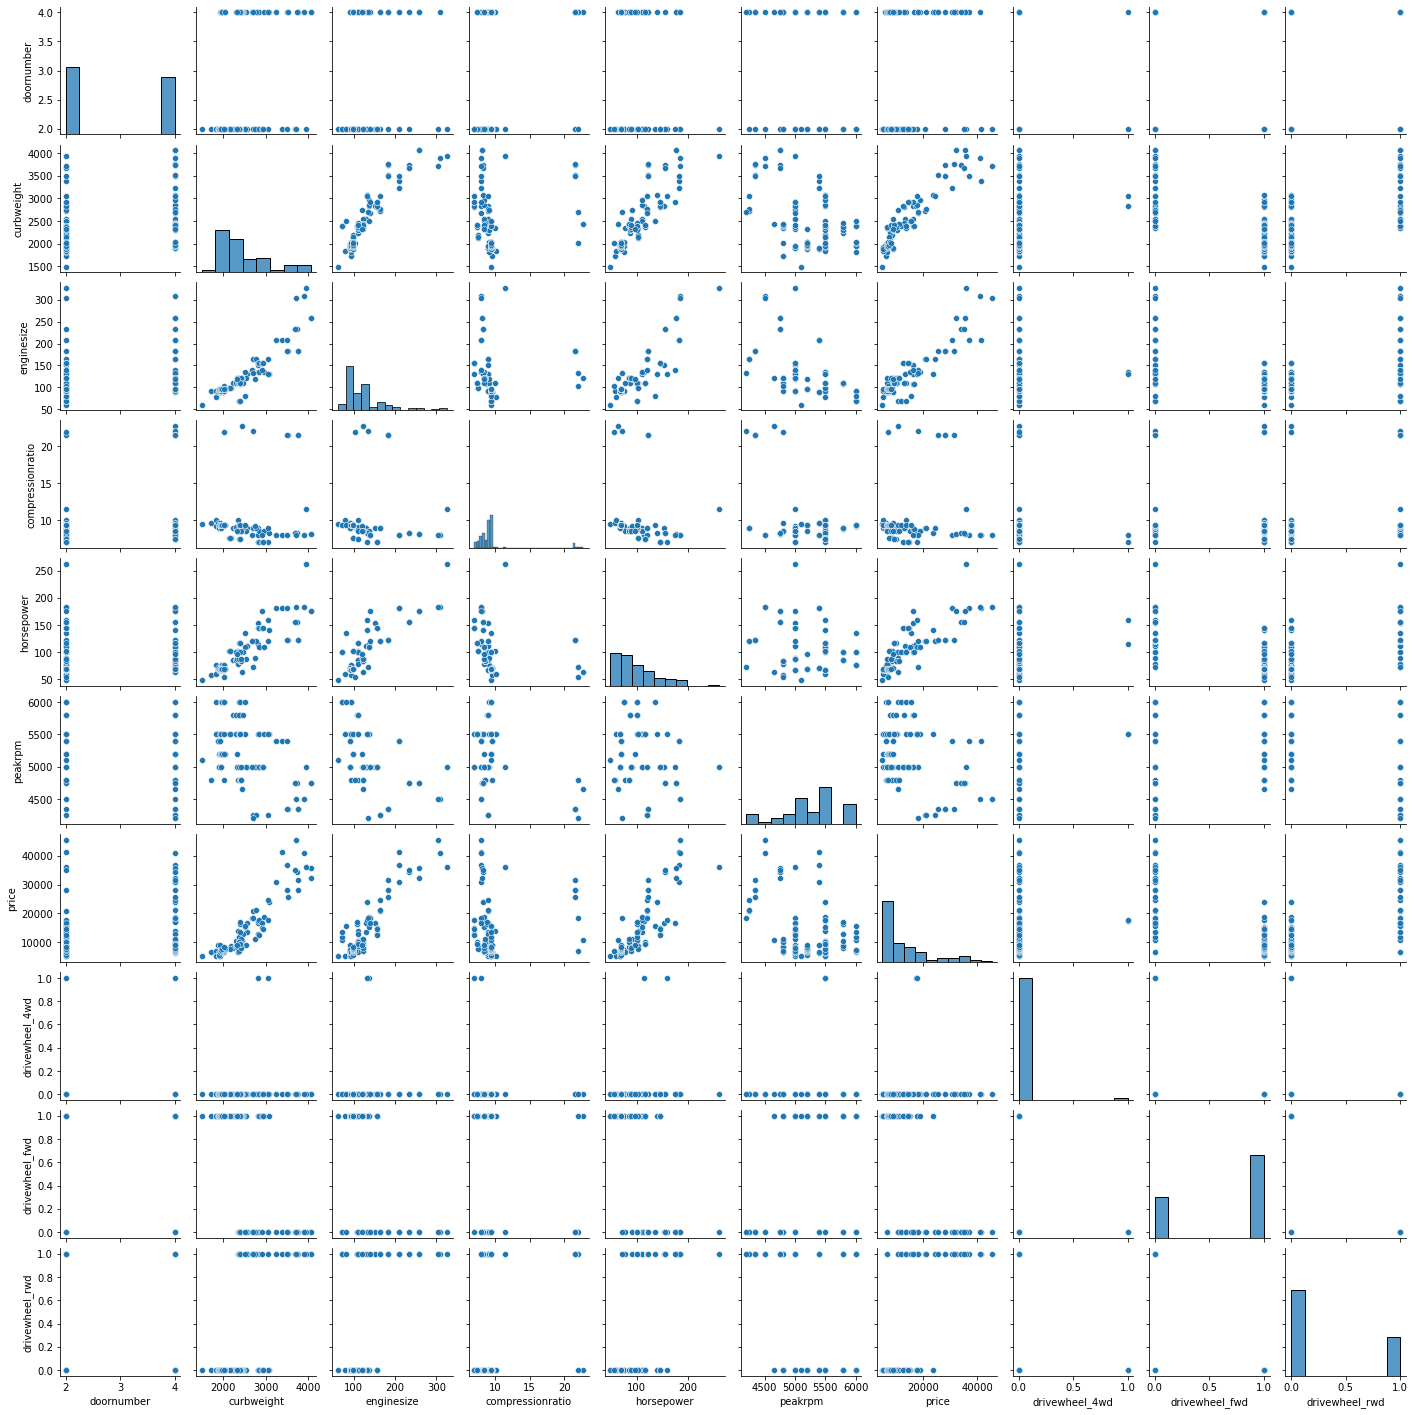

In [18]:
sns.pairplot(wDF[:100], height=2.0)

So it looks like price might be correlated with `enginesize`, `curbweight` and `horsepower`. `drivewheel_rwd` might also be correlated, but it's harder to tell because it is categorical. One thing to note with this basic analysis is that the scames for the various quantities are not normalized (e.g. 0 < `compressionratio` < 30 but 4000 < `peakrpm` < 7000)

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


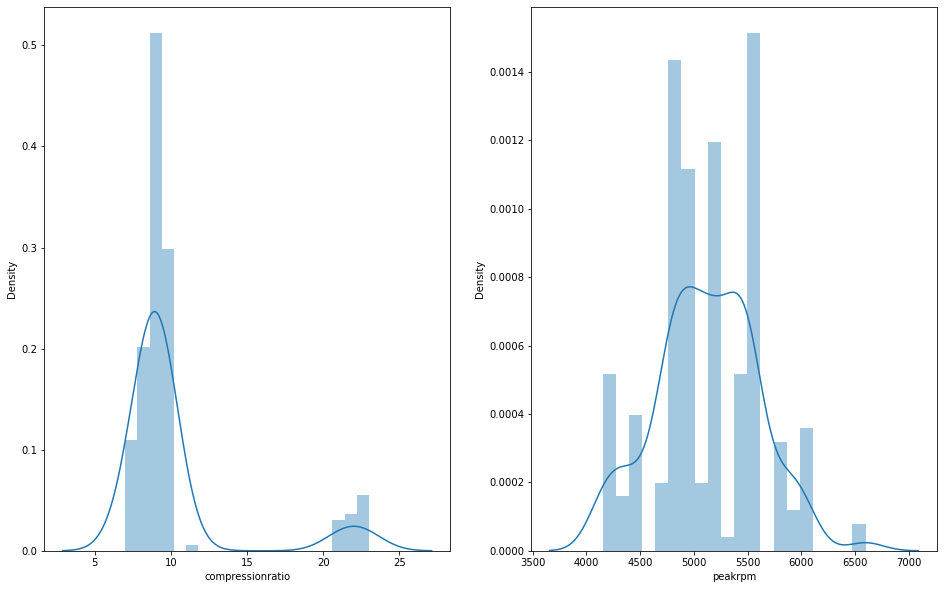

In [19]:
fig, ax  = plt.subplots(1, 2)
sns.distplot(wDF['compressionratio'], bins=20, ax=ax[0])
sns.distplot(wDF['peakrpm'], bins=20, ax=ax[1])
fig.show()


Another thing to note is that in a serious analysis the actual distributions that these things follow should be investigated and appropriate techniques for dealing with them selected. We'll try to gloss over that for now and just rescale things

## Part 2: Analysis & Model Building

We'll use sklearn for our model building. Addressing a point from above, we can rescale our numerical values so they fall in a standard range using the `StandardScaler` function. Basically, this will subtract the mean from each column and rescale it to have unit variance.

In [20]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_std = stdsc.fit_transform(wDF)

Now we can look at the correlation matrix between columns

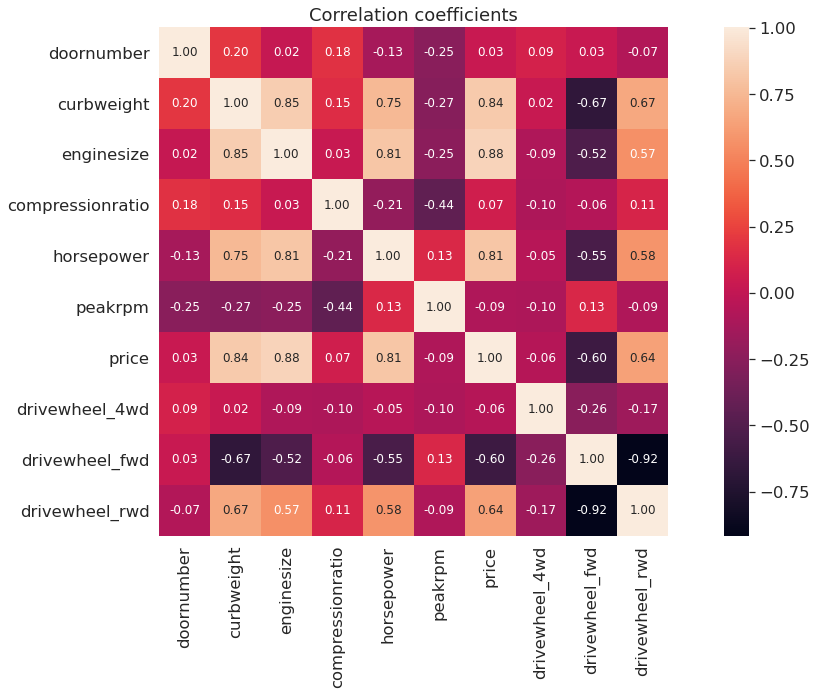

In [21]:
cov_mat =np.cov(X_std.T)

sns.set(font_scale=1.5)
hm = sns.heatmap(
    cov_mat,
    cbar = True,
    annot = True,
    square = True,
    fmt = '.2f',
    annot_kws = {'size': 12},
    yticklabels = wDF.columns,
    xticklabels = wDF.columns
)
plt.title('Correlation coefficients')
plt.tight_layout()
plt.show()

More systematically, we can examine the Pearson Correlation cofficients

In [22]:

selected_cols = ['curbweight', 'horsepower', 'enginesize', 'drivewheel_fwd', 'drivewheel_rwd', 'price']

In [24]:
wDF[selected_cols].head()

,curbweight,horsepower,enginesize,drivewheel_fwd,drivewheel_rwd,price
0,2548,111,130,0,1,13495.0
1,2548,111,130,0,1,16500.0
2,2823,154,152,0,1,16500.0
3,2337,102,109,1,0,13950.0
4,2824,115,136,0,0,17450.0


In [25]:
X = wDF[selected_cols].iloc[:,0:4].values # Features
y = wDF[selected_cols]['price'].values    # Targe variable

In [26]:
X.shape[0] == y.shape[0]

True

In [33]:
X_train

array([[2191,  102,   98,    1],
       [3197,   95,  152,    0],
       [2212,   85,  109,    1],
       [2756,  207,  194,    0],
       [2734,   90,  119,    0],
       [2661,  110,  136,    1],
       [2952,  114,  141,    0],
       [2140,   70,   98,    1],
       [2410,   84,  122,    1],
       [2823,  154,  152,    0],
       [2385,   84,  122,    1],
       [2535,   88,  122,    1],
       [2818,  145,  156,    0],
       [2337,   78,  111,    0],
       [2395,  101,  108,    0],
       [3230,   97,  120,    0],
       [3900,  184,  308,    0],
       [2935,  114,  141,    0],
       [2261,   52,   97,    1],
       [1985,   62,   92,    1],
       [2008,   69,   97,    1],
       [2337,  102,  109,    1],
       [2024,   69,   97,    1],
       [1918,   68,   90,    1],
       [2094,   70,   98,    1],
       [3157,  162,  130,    0],
       [1890,   68,   91,    1],
       [2548,  111,  130,    0],
       [1951,   69,   97,    1],
       [3252,   95,  152,    0],
       [20

## Data partitioning

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4, random_state=0)

In [29]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

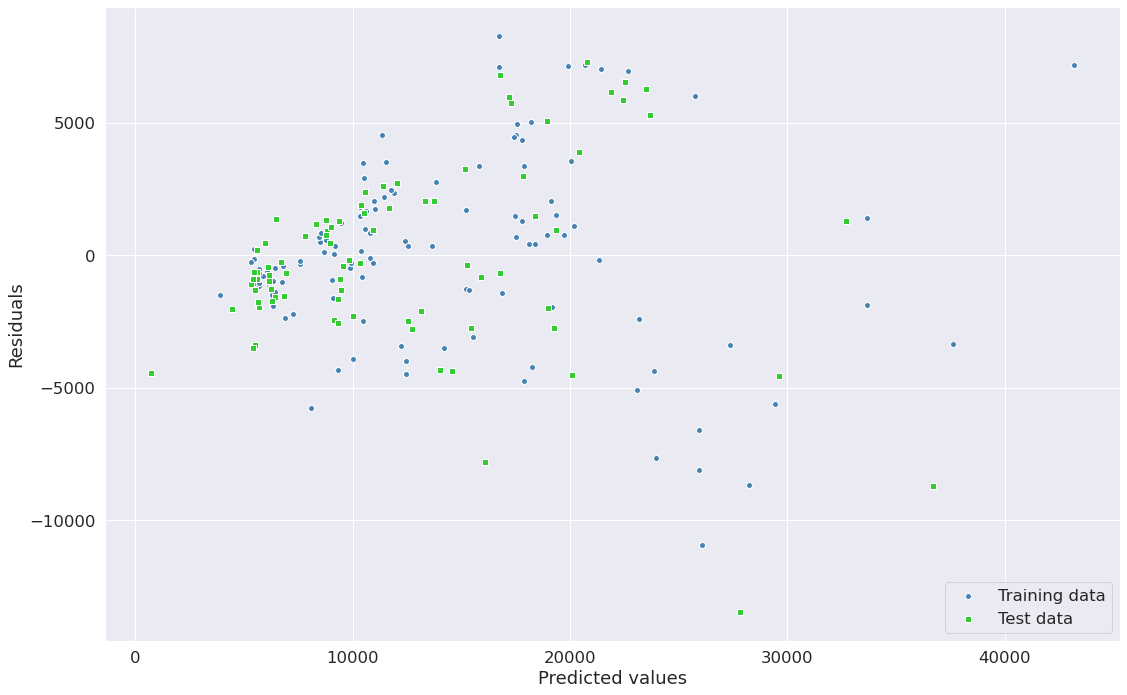

In [30]:
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.legend(loc='lower right')
plt.show()

## How did we do?

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

# Regression coefficients


In [ ]:
slr.fit(X_train, y_train).intercept_

In [ ]:
slr.fit(X_train, y_train).coef_


In [ ]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
sc_y = StandardScaler()
sc_x = StandardScaler()
y_std = sc_y.fit_transform(y_train[:, np.newaxis]).flatten()

In [ ]:
train_score = []
test_score = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4, random_state=i)
    y_train_std = sc_y.fit_transform(y_train[:, np.newaxis]).flatten()
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.linear_model import LinearRegression
    from sklearn.pipeline import Pipeline
    pipe_lr = Pipeline([('scl', StandardScaler()),('pca', PCA(n_components=4)),('slr', LinearRegression())])
    pipe_lr.fit(X_train, y_train_std)
    y_train_pred_std=pipe_lr.predict(X_train)
    y_test_pred_std=pipe_lr.predict(X_test)
    y_train_pred=sc_y.inverse_transform(y_train_pred_std)
    y_test_pred=sc_y.inverse_transform(y_test_pred_std)
    train_score = np.append(train_score, r2_score(y_train, y_train_pred))
    test_score = np.append(test_score, r2_score(y_test, y_test_pred))

In [ ]:
train_score


In [ ]:
test_score


In [ ]:
print('R2 train: %.3f +/- %.3f' % (np.mean(train_score),np.std(train_score)))


In [ ]:
print('R2 test: %.3f +/- %.3f' % (np.mean(test_score),np.std(test_score)))


## PCA

In [ ]:
train_score = []
test_score = []
cum_variance = []

In [ ]:
for i in range(1,5):
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4, random_state=0)
    y_train_std = sc_y.fit_transform(y_train[:, np.newaxis]).flatten()
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.linear_model import LinearRegression
    from sklearn.pipeline import Pipeline
    pipe_lr = Pipeline([('scl', StandardScaler()),('pca', PCA(n_components=i)),('slr', LinearRegression())])
    pipe_lr.fit(X_train, y_train_std)
    y_train_pred_std=pipe_lr.predict(X_train)
    y_test_pred_std=pipe_lr.predict(X_test)
    y_train_pred=sc_y.inverse_transform(y_train_pred_std)
    y_test_pred=sc_y.inverse_transform(y_test_pred_std)
    train_score = np.append(train_score, r2_score(y_train, y_train_pred))
    test_score = np.append(test_score, r2_score(y_test, y_test_pred))
    cum_variance = np.append(cum_variance, np.sum(pipe_lr.fit(X_train, y_train).named_steps['pca'].explained_variance_ratio_))

In [ ]:
train_score

In [8]:
test_score


NameError: name 'test_score' is not defined

In [9]:
cum_variance


NameError: name 'cum_variance' is not defined

In [10]:
plt.scatter(cum_variance,train_score, label = 'train_score')
plt.plot(cum_variance, train_score)
plt.scatter(cum_variance,test_score, label = 'test_score')
plt.plot(cum_variance, test_score)
plt.xlabel('cumulative variance')
plt.ylabel('R2_score')
plt.legend()
plt.show()

NameError: name 'cum_variance' is not defined

In [11]:
wDF.shape

NameError: name 'wDF' is not defined